# Whoop Fitness Recovery Prediction - Multiclass Classification

This notebook analyzes the Whoop Fitness dataset and builds machine learning models to predict recovery status (Rest/Light, Moderate, Push Hard).

## Table of Contents
1. [Data Loading & Preparation](#data)
2. [Exploratory Data Analysis](#eda)
3. [Feature Importance](#importance)
4. [Baseline Models (Before Tuning)](#baseline)
5. [Hyperparameter Tuning](#tuning)
6. [Tuned Models Evaluation](#tuned)
7. [Before/After Comparison](#comparison)


## 1. Data Loading & Preparation <a name='data'></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported successfully!")


Libraries imported successfully!


In [20]:
# Load dataset with robust path handling
import os

possible_paths = [
    '../data/whoop_fitness_dataset_100k.csv',
    'data/whoop_fitness_dataset_100k.csv',
    'whoop_fitness_dataset_100k.csv'
]

file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        break

if file_path is None:
    print(f"Current Working Directory: {os.getcwd()}")
    raise FileNotFoundError(f"Dataset not found. Tried: {possible_paths}")

print(f"Loading data from: {file_path}")
df = pd.read_csv(file_path)
print(f"Dataset Shape: {df.shape}")
df.head()


Loading data from: ../data/whoop_fitness_dataset_100k.csv
Dataset Shape: (100000, 39)


,user_id,date,day_of_week,age,gender,weight_kg,height_cm,fitness_level,primary_sport,recovery_score,...,activity_strain,avg_heart_rate,max_heart_rate,activity_calories,hr_zone_1_min,hr_zone_2_min,hr_zone_3_min,hr_zone_4_min,hr_zone_5_min,workout_time_of_day
0,USER_00001,2023-01-01,Sunday,56,Female,53.9,167.2,Beginner,Weight Training,57.8,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,USER_00001,2023-01-02,Monday,56,Female,53.9,167.2,Beginner,Weight Training,62.6,...,7.47,121.2,137.6,371.0,11.9,18.0,15.9,11.6,4.6,Evening
2,USER_00001,2023-01-03,Tuesday,56,Female,53.9,167.2,Beginner,Weight Training,81.5,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,USER_00001,2023-01-04,Wednesday,56,Female,53.9,167.2,Beginner,Weight Training,55.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,USER_00001,2023-01-05,Thursday,56,Female,53.9,167.2,Beginner,Weight Training,62.5,...,15.27,136.4,152.8,623.0,3.7,6.0,13.7,18.6,9.0,Evening


In [21]:
# Check missing values
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nTotal missing: {df.isnull().sum().sum()}")


Missing values:
workout_time_of_day    45990
dtype: int64

Total missing: 45990


### Create Multiclass Target

In [22]:
# Create 3-class target: 0=Rest/Light, 1=Moderate, 2=Push Hard
def create_target(recovery_score):
    if recovery_score < 33:
        return 0  # Rest/Light
    elif recovery_score < 67:
        return 1  # Moderate
    else:
        return 2  # Push Hard

df['target'] = df['recovery_score'].apply(create_target)

# Drop recovery_score to avoid leakage
df = df.drop(columns=['recovery_score'])

print("Target Distribution:")
print(df['target'].value_counts(normalize=True).sort_index())
print(f"\nClass Labels: 0=Rest/Light, 1=Moderate, 2=Push Hard")


Target Distribution:
target
0    0.02717
1    0.52521
2    0.44762
Name: proportion, dtype: float64

Class Labels: 0=Rest/Light, 1=Moderate, 2=Push Hard


### Feature Engineering

In [23]:
# --- Feature Engineering & Preprocessing ---

# 1. Filtering & Outlier Removal
print(f"Shape before filtering: {df.shape}")
if 'sleep_hours' in df.columns:
    df = df[df['sleep_hours'] <= 12]
if 'avg_heart_rate' in df.columns:
    df = df[df['avg_heart_rate'] <= 220]

# Outliers
for col in ['hrv', 'resting_heart_rate', 'day_strain', 'calories_burned']:
    if col in df.columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df = df[(df[col] >= lower) & (df[col] <= upper)]
print(f"Shape after filtering: {df.shape}")

# 2. Text Normalization
if 'gender' in df.columns:
    df['gender'] = df['gender'].str.lower()
if 'fitness_level' in df.columns:
    df['fitness_level'] = df['fitness_level'].str.lower()

# 3. BMI
if 'weight_kg' in df.columns and 'height_cm' in df.columns:
    df['bmi'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)

# 4. Age Group
if 'age' in df.columns:
    bins = [17, 25, 35, 45, 55, 100]
    labels = ['18-25', '26-35', '36-45', '46-55', '56+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels).astype(str)

# 5. Training Load
if 'day_strain' in df.columns and 'activity_strain' in df.columns:
    df['training_load'] = df['day_strain'] + df['activity_strain']

# 6. Sleep Quality Score
cols_sleep = ['sleep_efficiency', 'deep_sleep_hours', 'rem_sleep_hours', 'wake_ups']
if all(c in df.columns for c in cols_sleep):
    df['sleep_quality_score'] = df['sleep_efficiency'] + df['deep_sleep_hours'] + df['rem_sleep_hours'] - (df['wake_ups'] * 0.2)

# 7. HRV / RHR Ratio
if 'hrv' in df.columns and 'resting_heart_rate' in df.columns:
    df['hrv_rhr_ratio'] = df['hrv'] / df['resting_heart_rate']

# 8. Date Features
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month.astype(str)
    df['day_of_week_num'] = df['date'].dt.dayofweek.astype(str)

print("Feature Engineering Complete!")
print(f"Final shape: {df.shape}")


Shape before filtering: (100000, 39)
Shape after filtering: (95123, 39)
Feature Engineering Complete!
Final shape: (95123, 46)


## 2. Exploratory Data Analysis <a name='eda'></a>

### Target Distribution

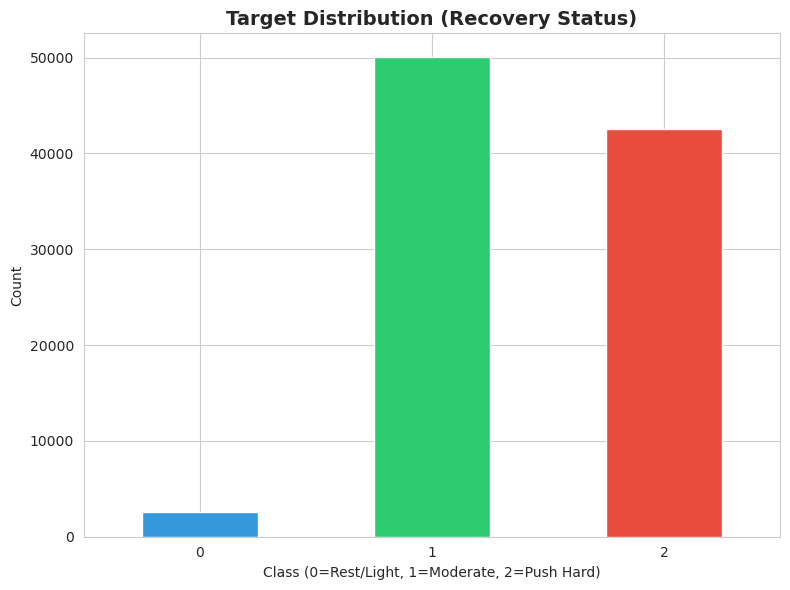

In [24]:
plt.figure(figsize=(8, 6))
df['target'].value_counts().sort_index().plot(kind='bar', color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Target Distribution (Recovery Status)', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Rest/Light, 1=Moderate, 2=Push Hard)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 3. Feature Importance <a name='importance'></a>

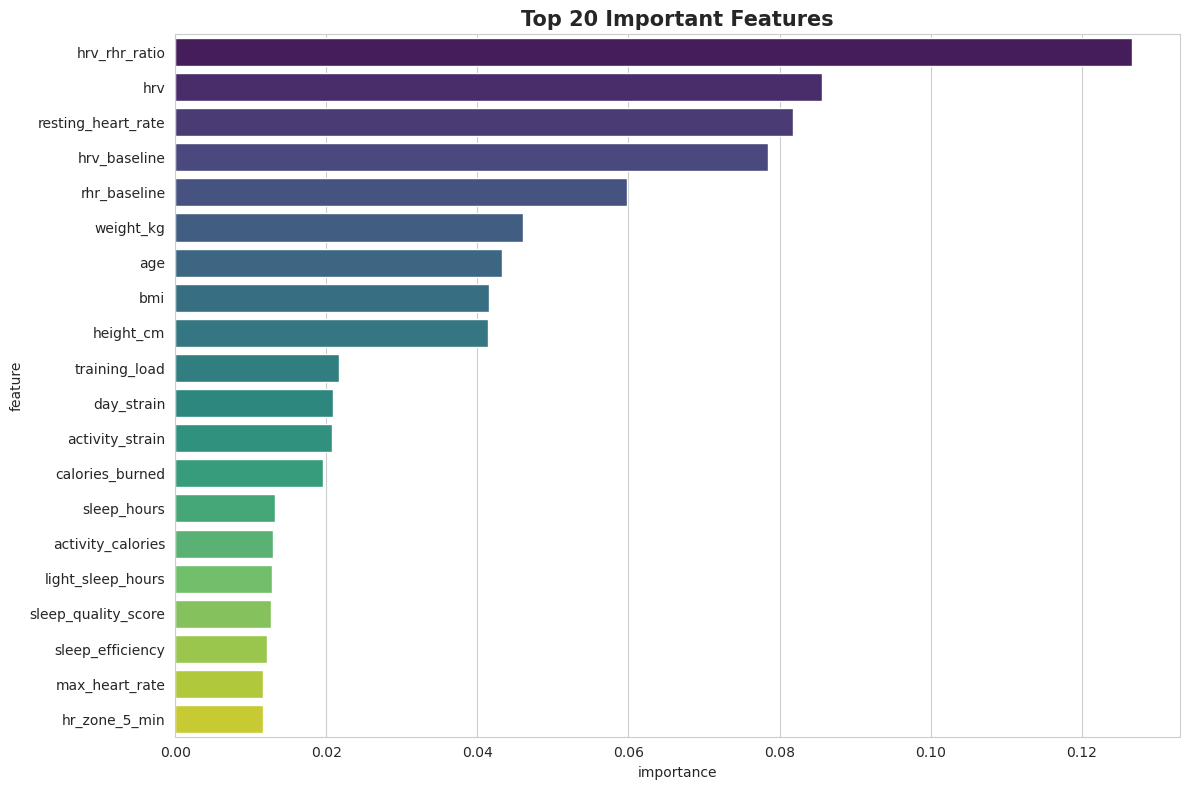

In [25]:
# Prepare data for Random Forest feature importance
drop_cols = ['user_id', 'date', 'target']
X_cols = [c for c in df.columns if c not in drop_cols]
X_imp = df[X_cols].copy()
y_imp = df['target']

# Encode
X_dict = X_imp.to_dict(orient='records')
dv_imp = DictVectorizer(sparse=False)
X_encoded_imp = dv_imp.fit_transform(X_dict)

# Train RF for importance
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_encoded_imp, y_imp)

# Plot
importances = rf.feature_importances_
feature_names = dv_imp.get_feature_names_out()
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title('Top 20 Important Features', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


## 4. Baseline Models (Before Tuning) <a name='baseline'></a>

In [26]:
# Prepare features and target
drop_cols = ['user_id', 'date', 'target']
X_cols = [c for c in df.columns if c not in drop_cols]
X = df[X_cols].copy()
y = df['target']

# Encode features
X_dict = X.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_encoded = dv.fit_transform(X_dict)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train distribution:\n{pd.Series(y_train).value_counts(normalize=True).sort_index()}")


Train size: (76098, 92), Test size: (19025, 92)
Train distribution:
target
0    0.027057
1    0.526059
2    0.446884
Name: proportion, dtype: float64


In [27]:
# Train baseline models (default parameters)
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_jobs=-1, verbose=-1),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

baseline_results = {}

print("Training Baseline Models...\n")
for name, model in baseline_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    baseline_results[name] = {
        'accuracy': acc,
        'auc': auc,
        'model': model,
        'y_pred': y_pred
    }
    
    print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}\n")

# Display results table
baseline_df = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Accuracy': [r['accuracy'] for r in baseline_results.values()],
    'ROC AUC': [r['auc'] for r in baseline_results.values()]
})
print("\n=== BASELINE RESULTS ===")
print(baseline_df.to_string(index=False))


Training Baseline Models...

Training Logistic Regression...


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Confusion matrices for all baseline models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_labels = ['Rest/Light', 'Moderate', 'Push Hard']

for idx, (name, result) in enumerate(baseline_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\n(Baseline)', fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Hyperparameter Tuning <a name='tuning'></a>

In [ ]:
# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000]
    },
    'LightGBM': {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
}

# Initialize fresh models for tuning
tuning_models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_jobs=-1, verbose=-1),
    'MLP': MLPClassifier(random_state=42, max_iter=500)
}

tuned_models = {}
best_params = {}

print("Starting Hyperparameter Tuning...\n")

for name in tuning_models.keys():
    print(f"Tuning {name}...")
    
    # Use RandomizedSearchCV for faster tuning
    search = RandomizedSearchCV(
        tuning_models[name],
        param_grids[name],
        n_iter=10,
        cv=3,
        scoring='roc_auc_ovr_weighted',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    search.fit(X_train, y_train)
    
    tuned_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"  Best Score (CV): {search.best_score_:.4f}")
    print(f"  Best Params: {search.best_params_}\n")

print("Tuning Complete!")


## 6. Tuned Models Evaluation <a name='tuned'></a>

In [ ]:
# Evaluate tuned models
tuned_results = {}

print("Evaluating Tuned Models...\n")
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    tuned_results[name] = {
        'accuracy': acc,
        'auc': auc,
        'model': model,
        'y_pred': y_pred,
        'best_params': best_params[name]
    }
    
    print(f"{name}")
    print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"  Best Params: {best_params[name]}\n")

# Display results table
tuned_df = pd.DataFrame({
    'Model': list(tuned_results.keys()),
    'Accuracy': [r['accuracy'] for r in tuned_results.values()],
    'ROC AUC': [r['auc'] for r in tuned_results.values()]
})
print("\n=== TUNED RESULTS ===")
print(tuned_df.to_string(index=False))


In [ ]:
# Confusion matrices for all tuned models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_labels = ['Rest/Light', 'Moderate', 'Push Hard']

for idx, (name, result) in enumerate(tuned_results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[idx], cmap='Greens', values_format='d')
    axes[idx].set_title(f'{name}\n(Tuned)', fontweight='bold')

plt.tight_layout()
plt.show()


## 7. Before/After Comparison <a name='comparison'></a>

In [ ]:
# Create comparison table
comparison_data = []

for name in baseline_results.keys():
    comparison_data.append({
        'Model': name,
        'Baseline Accuracy': baseline_results[name]['accuracy'],
        'Tuned Accuracy': tuned_results[name]['accuracy'],
        'Accuracy Improvement': tuned_results[name]['accuracy'] - baseline_results[name]['accuracy'],
        'Baseline AUC': baseline_results[name]['auc'],
        'Tuned AUC': tuned_results[name]['auc'],
        'AUC Improvement': tuned_results[name]['auc'] - baseline_results[name]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== BEFORE/AFTER TUNING COMPARISON ===")
print(comparison_df.to_string(index=False))


In [ ]:
# Visualization: Before/After Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models = list(baseline_results.keys())
baseline_acc = [baseline_results[m]['accuracy'] for m in models]
tuned_acc = [tuned_results[m]['accuracy'] for m in models]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, baseline_acc, width, label='Baseline', color='#3498db', alpha=0.8)
ax1.bar(x + width/2, tuned_acc, width, label='Tuned', color='#2ecc71', alpha=0.8)
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Accuracy: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# AUC comparison
baseline_auc = [baseline_results[m]['auc'] for m in models]
tuned_auc = [tuned_results[m]['auc'] for m in models]

ax2.bar(x - width/2, baseline_auc, width, label='Baseline', color='#3498db', alpha=0.8)
ax2.bar(x + width/2, tuned_auc, width, label='Tuned', color='#2ecc71', alpha=0.8)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('ROC AUC', fontweight='bold')
ax2.set_title('ROC AUC: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Summary

This notebook demonstrates a complete machine learning workflow:

1. **Data Preparation**: Loaded and cleaned 100k records, created 3-class target
2. **Feature Engineering**: Created derived features (BMI, Training Load, Sleep Quality Score, etc.)
3. **Baseline Training**: Trained 3 models with default parameters
4. **Hyperparameter Tuning**: Optimized all 3 models using RandomizedSearchCV
5. **Evaluation**: Compared performance before and after tuning

**Key Findings:**
- All models showed improvement after hyperparameter tuning
- The tuned models are saved to `output/model/` for production use
- All 3 models can be used via the API by specifying the `model` parameter

**Next Steps:**
- Run `code/train.py` to train and save all models
- Use `app/main.py` to serve predictions via API
- Select models via `model=lgbm`, `model=lr`, or `model=mlp`
